In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.models.gaussian_process import *


from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-30 10:07:46.704148: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 10:07:47.390259: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


## Do the entropy estimators give correct values for gaussian processes

In [2]:
# Compute a "true" reference covariance matrix
num_images = 5000
num_patches = 15000
# num_images = 1000
# num_patches = 1000
edge_crop = 32
# patch_size = 50
patch_size = 20
channel = 'LED119'
eigenvalue_floor = 1e-3


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=eigenvalue_floor)
gp = StationaryGaussianProcess(patches, eigenvalue_floor=eigenvalue_floor)
cov_mat_stationary_pd = gp.get_cov_mat()
gp.fit(patches)
cov_mat_stationary_optimized = gp.get_cov_mat()


2023-10-30 10:10:14.602486: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 2567.30


Epoch 1: 100%|██████████| 1/1 [00:10<00:00, 10.20s/it]


Epoch 1: validation NLL: 4.27


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Epoch 2: validation NLL: 4.25


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 18.21it/s]


Epoch 3: validation NLL: 4.24


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Epoch 4: validation NLL: 4.25


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Epoch 5: validation NLL: 4.25


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


Epoch 6: validation NLL: 4.25


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


Epoch 7: validation NLL: 4.25


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


Epoch 8: validation NLL: 4.25


### Now verify that mutual information estimates converge to the true value with increasing number of samples

In [3]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it
from encoding_information.models.gaussian_process import StationaryGaussianProcess

num_images = 10000
num_patches = 10000
# num_images = 1000
# num_patches = 1000
edge_crop = 24

patch_size = 15

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = estimate_full_cov_mat(patches)
gp = StationaryGaussianProcess(patches)
gp.fit(patches)
true_cov_mat_px = gp.get_cov_mat()
true_mean_px = np.mean(images)
samples = gp.generate_samples(num_samples=num_patches, sample_shape=patch_size, ensure_nonnegative=True)

Initial validation NLL: 12079.07


Epoch 1: 100%|██████████| 1/1 [00:05<00:00,  5.95s/it]


Epoch 1: validation NLL: 3184.58


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 29.23it/s]


Epoch 2: validation NLL: 4.94


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 28.79it/s]


Epoch 3: validation NLL: 4.93


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


Epoch 4: validation NLL: 4.92


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 30.09it/s]


Epoch 5: validation NLL: 4.92


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 28.56it/s]


Epoch 6: validation NLL: 4.92


Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 29.26it/s]


Epoch 7: validation NLL: 4.91


Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 27.54it/s]


Epoch 8: validation NLL: 4.91


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 29.65it/s]


Epoch 9: validation NLL: 4.91


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 29.20it/s]


Epoch 10: validation NLL: 4.91


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 29.85it/s]


Epoch 11: validation NLL: 4.91


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 29.03it/s]


Epoch 12: validation NLL: 4.91


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 29.88it/s]


Epoch 13: validation NLL: 4.91


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 28.95it/s]


Epoch 14: validation NLL: 4.91


### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 


This all uses additive gaussian noise, which has an easy analytic formula for h(y | x)

In [4]:
from encoding_information.models.gaussian_process import gaussian_likelihood, nll_per_pixel_from_cov_mat
from encoding_information.models.pixel_cnn import PixelCNN

# num_samples_to_use = np.array([10, 40, 160,]).astype(int)
num_bootstrap_samples = 80

# num_samples_to_use = np.array([10, 40, 160, 640, 2560, 10240]).astype(int)
num_samples_to_use = np.array([10, 40, 160, 640, 2560]).astype(int)


gaussian_sigma = 50
confidence_interval = 90


def gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=1e-1, optimize=True):
    num_train = int(max(2, min(1000, 0.1 * data.shape[0])))
    train_data = data[:num_train]
    test_data = data[num_train:]
    if stationary:
        gp = StationaryGaussianProcess(train_data, eigenvalue_floor=eigenvalue_floor)
        if optimize:
            num_val_samples = max(1, min(1000, 0.1 * train_data.shape[0]))
            gp.fit(train_data, num_val_samples=num_val_samples, verbose=False)
        nll_per_pixel = gp.compute_negative_log_likelihood(test_data, verbose=False)
        
    else:
        cov_mat = estimate_full_cov_mat(train_data)
        nll_per_pixel = nll_per_pixel_from_cov_mat(cov_mat, train_data.mean(axis=0).reshape(-1), train_data, np.prod(onp.array(test_data.shape)[1:]))
    return nll_per_pixel

def pixelcnn_entropy_estimate(data):
    num_train = int(max(2, min(1000, 0.1 * data.shape[0])))
    num_val_samples = int(max(1, min(1000, 0.1 * num_train)))
    train_data = data[:num_train]
    test_data = data[num_train:]
    model = PixelCNN()
    model.fit(train_data, num_val_samples=num_val_samples, max_epochs=25, verbose=False)
    nll_per_pixel = model.compute_negative_log_likelihood(test_data)
    return nll_per_pixel


h_x_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_px) 
true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_given_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_given_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)


full_cov_h_y_estimates_mean = []
full_cov_h_y_estimates_conf_int = []
stationary_h_y_estimates_mean = []
stationary_h_y_estimates_conf_int = []
stationary_h_y_estimates_optimized_mean = []
stationary_h_y_estimates_optimized_conf_int = []
pixelcnn_h_y_estimates_mean = []
pixelcnn_h_y_estimates_conf_int = []


h_y_given_x_estimates_mean = []
h_y_given_x_estimates_conf_int = []


ev_floor = 1e-1
for num_to_use in tqdm(num_samples_to_use):
    # check for a cached version of this
    # create cache folder if it doesn't exist
    if not os.path.exists('.cache'):
        os.mkdir('.cache')
    if os.path.exists('.cache/entropy_estimates_cache_{}_samples.npz'.format(num_to_use)):
        print('loading cached version of entropy estimates')
        loaded = onp.load('entropy_estimates_cache_{}_samples.npz'.format(num_to_use))
        # append to the list of estimates
        full_cov_h_y_estimates_conf_int.append(loaded['full_cov_h_y_estimates_conf_int'])
        full_cov_h_y_estimates_mean.append(loaded['full_cov_h_y_estimates_mean'])
        stationary_h_y_estimates_conf_int.append(loaded['stationary_h_y_estimates_conf_int'])
        stationary_h_y_estimates_mean.append(loaded['stationary_h_y_estimates_mean'])
        stationary_h_y_estimates_optimized_conf_int.append(loaded['stationary_h_y_estimates_optimized_conf_int'])
        stationary_h_y_estimates_optimized_mean.append(loaded['stationary_h_y_estimates_optimized_mean'])
        pixelcnn_h_y_estimates_conf_int.append(loaded['pixelcnn_h_y_estimates_conf_int'])
        pixelcnn_h_y_estimates_mean.append(loaded['pixelcnn_h_y_estimates_mean'])
        h_y_given_x_estimates_conf_int.append(loaded['h_y_given_x_estimates_conf_int'])
        h_y_given_x_estimates_mean.append(loaded['h_y_given_x_estimates_mean'])
    else:

        print(f'Computing with {num_to_use} samples')

        print('full covariance gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval, verbose=True )
        full_cov_h_y_estimates_mean.append(mean)
        full_cov_h_y_estimates_conf_int.append(conf_int)

        print('stationary gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, ), confidence_interval=confidence_interval, verbose=True)
        stationary_h_y_estimates_mean.append(mean)
        stationary_h_y_estimates_conf_int.append(conf_int)

        print('optimized stationary gp')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, optimize=True), confidence_interval=confidence_interval, verbose=True )
        stationary_h_y_estimates_optimized_mean.append(mean)
        stationary_h_y_estimates_optimized_conf_int.append(conf_int)

        print('pixelcnn')
        mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: pixelcnn_entropy_estimate(data), confidence_interval=confidence_interval, verbose=True )
        pixelcnn_h_y_estimates_mean.append(mean)
        pixelcnn_h_y_estimates_conf_int.append(conf_int)


        # estimate conditional entropy
        mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                        lambda data: estimate_conditional_entropy(data), confidence_interval=confidence_interval, verbose=True )
        h_y_given_x_estimates_mean.append(mean)
        h_y_given_x_estimates_conf_int.append(conf_int)


        # save all these results to a numpy file
        onp.savez('.cache/entropy_estimates_cache_{}_samples.npz'.format(num_to_use),
                    full_cov_h_y_estimates_conf_int=onp.array(full_cov_h_y_estimates_conf_int[-1]),
                    full_cov_h_y_estimates_mean=onp.array(full_cov_h_y_estimates_mean[-1]),
                    stationary_h_y_estimates_conf_int=onp.array(stationary_h_y_estimates_conf_int[-1]),
                    stationary_h_y_estimates_mean=onp.array(stationary_h_y_estimates_mean[-1]),
                    stationary_h_y_estimates_optimized_conf_int=onp.array(stationary_h_y_estimates_optimized_conf_int[-1]),
                    stationary_h_y_estimates_optimized_mean=onp.array(stationary_h_y_estimates_optimized_mean[-1]),
                    pixelcnn_h_y_estimates_conf_int=onp.array(pixelcnn_h_y_estimates_conf_int[-1]),
                    pixelcnn_h_y_estimates_mean=onp.array(pixelcnn_h_y_estimates_mean[-1]),
                    h_y_given_x_estimates_conf_int=onp.array(h_y_given_x_estimates_conf_int[-1]),
                    h_y_given_x_estimates_mean=onp.array(h_y_given_x_estimates_mean[-1]),
                    )
                

full_cov_h_y_estimates_conf_int = np.array(full_cov_h_y_estimates_conf_int)
full_cov_h_y_estimates_mean = np.array(full_cov_h_y_estimates_mean)
stationary_h_y_estimates_conf_int = np.array(stationary_h_y_estimates_conf_int)
stationary_h_y_estimates_mean = np.array(stationary_h_y_estimates_mean)
stationary_h_y_estimates_optimized_conf_int = np.array(stationary_h_y_estimates_optimized_conf_int)
stationary_h_y_estimates_optimized_mean = np.array(stationary_h_y_estimates_optimized_mean)

pixelcnn_h_y_estimates_conf_int = np.array(pixelcnn_h_y_estimates_conf_int)
pixelcnn_h_y_estimates_mean = np.array(pixelcnn_h_y_estimates_mean)

h_y_given_x_estimates_conf_int = np.array(h_y_given_x_estimates_conf_int)
h_y_given_x_estimates_mean = np.array(h_y_given_x_estimates_mean)


  0%|          | 0/5 [00:00<?, ?it/s]

Using 10 samples
full covariance gp


Running bootstraps: 100%|██████████| 80/80 [00:03<00:00, 24.68it/s]


stationary gp


Running bootstraps: 100%|██████████| 80/80 [06:44<00:00,  5.06s/it]


optimized stationary gp


Running bootstraps: 100%|██████████| 80/80 [06:51<00:00,  5.14s/it]


pixelcnn



2023-10-30 10:26:30.651492: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-30 10:26:30.651518: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,15,15]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,15,15]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}

Computing loss: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Computing loss: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Computing loss: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Computing loss: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Computing loss: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Computing loss: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Compu

KeyboardInterrupt: 

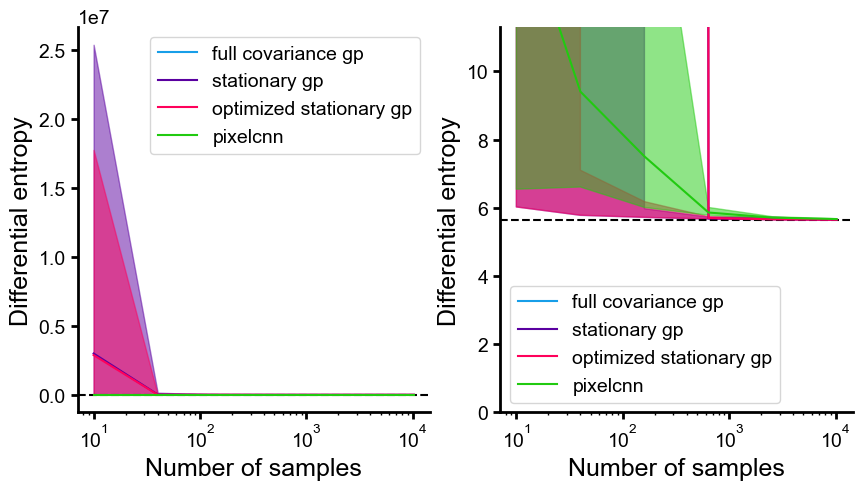

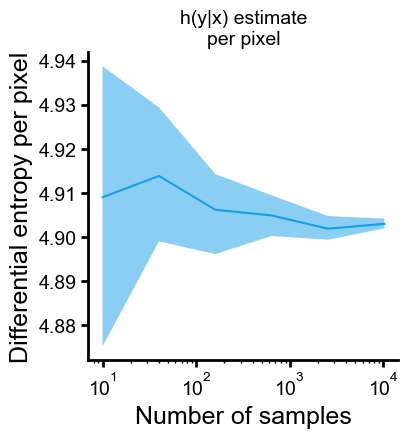

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].axhline(h_y_analytic, color='k', linestyle='--')

colors = get_color_cycle()

ax[0].fill_between(num_samples_to_use, full_cov_h_y_estimates_conf_int[:,0], full_cov_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[0])
ax[0].semilogx(num_samples_to_use, full_cov_h_y_estimates_mean, label='full covariance gp', color=colors[0])
ax[0].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[1])
ax[0].semilogx(num_samples_to_use, stationary_h_y_estimates_mean, label='stationary gp', color=colors[1])
ax[0].fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.25, color=colors[2])
ax[0].semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean, label='optimized stationary gp', color=colors[2])
ax[0].fill_between(num_samples_to_use, pixelcnn_h_y_estimates_conf_int[:,0], pixelcnn_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[3])
ax[0].semilogx(num_samples_to_use, pixelcnn_h_y_estimates_mean, label='pixelcnn', color=colors[3])

ax[0].set(xlabel='Number of samples', ylabel='Differential entropy')
ax[0].legend()
clear_spines(ax[0])

# Zoomed in
ax[1].axhline(h_y_analytic, color='k', linestyle='--')

ax[1].fill_between(num_samples_to_use, full_cov_h_y_estimates_conf_int[:,0], full_cov_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[0])
ax[1].semilogx(num_samples_to_use, full_cov_h_y_estimates_mean, label='full covariance gp', color=colors[0])
ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[1])
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_mean, label='stationary gp', color=colors[1])
ax[1].fill_between(num_samples_to_use, stationary_h_y_estimates_optimized_conf_int[:,0], stationary_h_y_estimates_optimized_conf_int[:,1], alpha=0.25, color=colors[2])
ax[1].semilogx(num_samples_to_use, stationary_h_y_estimates_optimized_mean, label='optimized stationary gp', color=colors[2])
ax[1].fill_between(num_samples_to_use, pixelcnn_h_y_estimates_conf_int[:,0], pixelcnn_h_y_estimates_conf_int[:,1], alpha=0.25, color=colors[3])
ax[1].semilogx(num_samples_to_use, pixelcnn_h_y_estimates_mean, label='pixelcnn', color=colors[3])

ax[1].set(xlabel='Number of samples', ylabel='Differential entropy')
ax[1].legend()
clear_spines(ax[1])
ax[1].set(ylim=(0, h_y_analytic * 2))

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'entropy_estimation_consistency' + '.pdf', transparent=True)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, h_y_given_x_estimates_conf_int[:, 0], h_y_given_x_estimates_conf_int[:, 1], alpha=0.5)
ax.semilogx(num_samples_to_use, h_y_given_x_estimates_mean)
ax.set(xlabel='Number of samples', title='h(y|x) estimate\nper pixel', ylabel='Differential entropy per pixel')
clear_spines(ax)


fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'conditional_entropy_consistency' + '.pdf', transparent=True)